GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name             | Type             | Params | Mode 
--------------------------------------------------------------
0 | criterion        | MSELoss          | 0      | train
1 | train_criterion  | MSELoss          | 0      | train
2 | val_criterion    | MSELoss          | 0      | train
3 | train_metrics    | MetricCollection | 0      | train
4 | val_metrics      | MetricCollection | 0      | train
5 | encoders         | Sequential       | 1.1 M  | train
6 | decoders         | Sequential       | 1.2 M  | train
7 | temporal_decoder | _ResidualBlock   | 594    | train
8 | lookback_skip    | Linear           | 156    | train
--------------------------------------------------------------
2.3 M     Trainable params
0         Non-trainable params
2.3 M     Total params
9.249     Total estimated model params size (MB)
43        Modules in train mode
0         Modules in eval mode

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

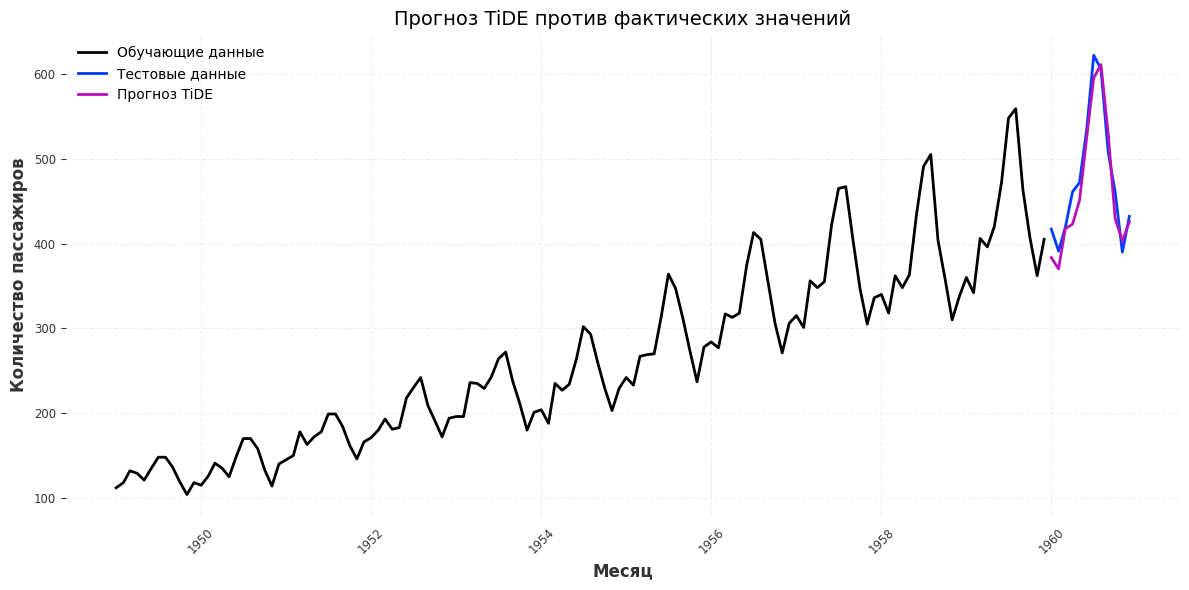

Среднеквадратичная ошибка TiDE: 22.36


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.models.forecasting.tide_model import TiDEModel
from darts.dataprocessing.transformers import Scaler
from sklearn.metrics import mean_squared_error

# Загрузка данных
data = pd.read_csv('AirPassengers.csv')
data["Month"] = pd.to_datetime(data["Month"]).dt.to_period("M").dt.to_timestamp()

# Определяем последний год для тестовой выборки
last_year = data["Month"].dt.year.max()

# Разделение данных: тренировочные и тестовые
train_data = data[data["Month"].dt.year < last_year]
test_data = data[data["Month"].dt.year == last_year]

# Подготовка временного ряда для Darts
train_series = TimeSeries.from_dataframe(train_data, time_col='Month', value_cols='#Passengers')
test_series = TimeSeries.from_dataframe(test_data, time_col='Month', value_cols='#Passengers')

# Масштабирование тренировочных данных
train_scaler = Scaler()
scaled_train = train_scaler.fit_transform(train_series)

# Инициализация модели TiDE
tide = TiDEModel(
    input_chunk_length=12,     # Длина входного окна данных для обучения модели
    output_chunk_length=12,    # Количество временных шагов в прогнозе
    num_encoder_layers=2,      # Количество слоев в энкодере
    num_decoder_layers=2,      # Количество слоев в декодере
    hidden_size=512,           # Размер скрытого слоя
    dropout=0.19,               # Дроп-аут для регуляризации
    random_state=42            # Установка случайного состояния для воспроизводимости
)

# Обучение модели
tide.fit(
    scaled_train,
    epochs=30,
)

# Прогнозирование на 12 месяцев вперед
forecast = tide.predict(n=12)

# Обратное преобразование для получения оригинальных значений
forecast = train_scaler.inverse_transform(forecast)

# Визуализация результатов
plt.figure(figsize=(12, 6))
train_series.plot(label='Обучающие данные', lw=2)
test_series.plot(label='Тестовые данные', lw=2)
forecast.plot(label='Прогноз TiDE', lw=2)

# Добавление заголовка и подписей к осям
plt.title("Прогноз TiDE против фактических значений", fontsize=14)
plt.xlabel("Месяц", fontsize=12)
plt.ylabel("Количество пассажиров", fontsize=12)
plt.legend()
plt.grid(visible=True, linestyle="--", alpha=0.5)
plt.xticks(rotation=45)
plt.tight_layout()

# Отображение графика
plt.show()

# Вычисление RMSE для TiDE
tide_rmse = np.sqrt(mean_squared_error(test_data["#Passengers"], forecast.values()))
print(f"Среднеквадратичная ошибка TiDE: {tide_rmse:.2f}")
